In [1]:
"""
Semi-supervised GAN (SGAN)
Semi-supervised refers to the training process where the model gets trained only
on a few labeled images but the data set contains a lot more unlabeled images. 
This can be useful in situations where you have a humongous data set but only 
partially labeled. 
In regular GAN the discriminator is trained in an unsupervised manner, where it
predicts whether the image is real or fake (binary classification). 
In SGAN, in addition to unsupervised, the discriminator gets trained in a 
supervised manner on class labels for real images (binary/multiclass classification). 
In essence, the unsupervised mode trains the discriminator to learn features and
the supervised mode trains on corresponding classes (labels). The GAN
can be trained using only a handful of labeled examples. 
In a standard GAN our focus is on training a generator that we want to use to generate
fake images. In SGAN, our goal is to train the discriminator to be an excellent classifier
using only a few labeled images. We can still use the generator to generate fake images but
our focus is on the discriminator. 
Why do we want to follow this path is CNNs can easily classify images?
Apparently, this approach achieves better accuracy for limited labeled data compared to CNNs. 
(https://arxiv.org/abs/1606.01583)
Another useful resource: https://arxiv.org/pdf/1606.03498.pdf​
"""

# example of semi-supervised gan for mnist
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, Lambda, Activation
from keras import losses

#from keras.utils import to_categorical

from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


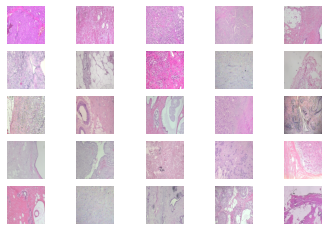

In [2]:
#Load data and plot to get a quick understanding

import os
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

#loading the saved file once again
tumor_final = np.load(os.path.join('/content/drive/MyDrive/Capstone','features_256_40.npy'), 
                allow_pickle=True)

#loading the saved file once again
target = np.load(os.path.join('/content/drive/MyDrive/Capstone','target_256_40.npy'), 
                allow_pickle=True)

# #loading the saved file once again
# tumor_final = np.load(os.path.join('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code/Features','features_256_40.npy'), 
#                 allow_pickle=True)

# #loading the saved file once again
# target = np.load(os.path.join('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code/Features','target_256_40.npy'), 
#                 allow_pickle=True)

trainX, testX, trainy, testy = train_test_split(tumor_final, target, test_size=0.2, random_state=42)

#(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()


In [3]:
#############################################################################
#Define generator, discriminator, gan and other helper functions
#Using Sequential method from Keras as it makes the definition of models easy.
#We will use functional way of defining the model for the conditional gan
#but sequential for descriminator and generator as they are straightforward.
#########################################################################

In [4]:
# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 256x256)
#latent_dim, for example, can be 100/60, 1D array of size 100/60 

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.       

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)

    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 64x64 image
    im_sz = int((256/2)/2)   # image size
# 	print(im_sz)
    n_nodes = 128 * im_sz * im_sz
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((im_sz, im_sz, 128))(gen)
    # upsample to 128x128
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 256x256
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output kernel size is tuned based on input data size
    out_layer = Conv2D(3, (5, 5), activation='tanh', padding='same')(gen)
    # define model
    model = Model(in_lat, out_layer)
   
    return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

In [5]:
gen_model=define_generator(60)
print(gen_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 524288)            31981568  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 524288)            0         
                                                                 
 reshape (Reshape)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 128)    262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                             

In [6]:
# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(256,256,3)):

    in_image = Input(shape=in_shape)
    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image) #128x128x128
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X) #64x64x128
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X) #32x32x128
    X = LeakyReLU(alpha=0.2)(X)

    # X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X) #64x64x128
    # X = LeakyReLU(alpha=0.2)(X)
    
    # X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X) #32x32x128
    # X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X) #shape of 8192
    #X = Dense(256, activation='relu', name='fc1')(X)
    X = Dropout(0.4)(X)
    X = Dense(1)(X) #shape of 1
    
    model = Model(inputs=in_image, outputs=X)
    
    return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0   

In [7]:
#Define the supervised discriminator. 
#binary classification, so we will use sigmoid activation.
#since our labels are categorical, we will work with binary crossentropy loss. 
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.00002, beta_1=0.5), 
                  loss=losses.BinaryCrossentropy(reduction="sum_over_batch_size"),metrics=['accuracy'])
    return model

In [8]:
#Define the unsupervised discriminator
#Takes the output of the supervised, just before the softmax activation. 
#Then, adds a layer with calculation of sum of exponential outputs. (defined below as custom_activation)
# Reference: https://arxiv.org/abs/1606.03498

#This custom activation layer gives a value close to 0 for smaller activations
#in the prior discriminator layer. It gives values close to 1 for large activations.
#This way it gives low activation for fake images. No need for sigmoid anymore.  

# custom activation function for the unsupervised discriminator
#D(x) = Z(x) / (Z(x) + 1) where Z(x) = sum(exp(l(x))). l(x) is the output from sup discr. prior to softmax
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)
    
    return D_x

In [9]:
#You can also try the built in tensorflow function: tf.reduce_logsumexp(class_logits, 1)

def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss=losses.BinaryCrossentropy(reduction="sum_over_batch_size"), optimizer=Adam(learning_rate=0.00002, beta_1=0.5))
    return model

In [10]:
disc=define_discriminator()
disc_sup=define_sup_discriminator(disc)
disc_unsup=define_unsup_discriminator(disc)
print(disc_unsup.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 1)                 429825    
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 429,825
Trainable params: 429,825
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(gen_model, disc_unsup):
	
	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc. 
	model = Model(gen_model.input, gan_output)
	model.compile(loss=losses.BinaryCrossentropy(reduction="sum_over_batch_size"), optimizer=Adam(learning_rate=0.00002, beta_1=0.5))
	return model

In [12]:
gan_model = define_gan(gen_model, disc_unsup)
print(gan_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 524288)            31981568  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 524288)            0         
                                                                 
 reshape (Reshape)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 128)    262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                           

In [13]:
# load the images
def load_real_samples(n_classes=2):
    trainX, _, trainy, _ = train_test_split(tumor_final, target, test_size=0.2, random_state=42)
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation. 
    print(X.shape, trainy.shape)
    return [X, trainy]

#data = load_real_samples()

In [14]:
#select subset of the dataset for supervised training
#Let us pick only 40 samples to be used in supervised training. 
#Also, we need to ensure we pick 20 samples per class to ensure a good balance
#of data between classes. 
def select_supervised_samples(dataset, n_samples=40, n_classes=2):
    X, y = dataset
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes) #Number of amples per class. 
    for i in range(n_classes):
        X_with_class = X[y == i] # get all images for this class
        ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
        [X_list.append(X_with_class[j]) for j in ix] # add to list
        [y_list.append(i) for j in ix]
    return asarray(X_list), asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y

In [15]:
# Pick real samples from the dataset.
#Return both images and corresponding labels in addition to y=1 indicating that the images are real. 
#Remember that we will not use the labels for unsupervised, only used for supervised. 
def generate_real_samples(dataset, n_samples):
    
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training) 
	return [X, labels], y

In [16]:
# generate latent points, to be used as inputs to the generator. 
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

In [17]:
# Generate fake images using the generator and above latent points as input to it. 
#We do not care about labeles so the generator will not know anything about the labels. 
def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training) 
	return fake_images, y

In [18]:
# report accuracy and save plots & the model periodically. 
sup_acc = [] 
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=200):
	# Generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
	
	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	#plt.savefig(filename1)
	plt.close()
    
	# evaluate the discriminator 
	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model 
	sup_acc.append(acc * 100) 
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	#gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	#disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))


In [19]:
# train the generator and discriminator
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	
    # select supervised dataset for training.
    #Remember that we are not using all images, just a subset (40 images, 20 per class. )
	X_sup, y_sup = select_supervised_samples(dataset)
	#print(X_sup.shape, y_sup.shape)
	
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs
	
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, 
                                                              n_batch, half_batch, 
                                                              bat_per_epo, n_steps))
	
    #  enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (disc_sup) on real samples.
        #Remember that we use real labels to train as this is supervised. 
        #This is the discriminator we really care about at the end.
        #Also, this is a binary classifier. Therefore, our y values 
        #will be the real class labels for breast cancer. (NOT 1 or 0 indicating real or fake.)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)
        
		# update unsupervised discriminator (disc_unsup) - just like in our regular GAN.
        #Remember that we will not train on labels as this is unsupervised, just binary as in our regular GAN.
        #The y_real below indicates 1s telling the discriminator that these images are real. 
        #do not confuse this with class labels. 
        #We will discard this discriminator at the end. 
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) #
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
        #Now train on fake. 
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)
        
		# update generator (gen) - like we do in regular GAN.
        #We can discard this model at the end as our primary goal is to train a binary classifier (sup. disc.)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)
        
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
		# evaluate the model performance periodically
		if (i+1) % (bat_per_epo * 1) == 0:
		#if (i+1) % 1000 == 0:
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)


In [ ]:
#################################################################################
# TRAIN
#################################

latent_dim = 60

# create the discriminator models
disc=define_discriminator() #Bare discriminator model... 
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model. 

gen_model = define_generator(latent_dim) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)

# train the model
# NOTE: 1 epoch = 199 steps in this example. 
train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=100, n_batch=4)

Streaming output truncated to the last 5000 lines.
>21057, c[0.484,100], d[0.508,0.903], g[0.601]
>21058, c[0.521,50], d[0.477,0.886], g[0.577]
>21059, c[1.003,0], d[1.219,0.884], g[0.534]
>21060, c[0.690,50], d[0.575,0.864], g[0.432]
>21061, c[0.351,100], d[0.531,1.354], g[0.582]
>21062, c[0.614,50], d[0.616,1.285], g[0.535]
>21063, c[0.578,50], d[0.929,0.815], g[0.694]
>21064, c[0.503,50], d[0.700,1.076], g[0.787]
>21065, c[0.691,50], d[0.736,1.017], g[0.644]
>21066, c[0.378,100], d[0.449,0.809], g[0.672]
>21067, c[0.427,100], d[0.812,0.821], g[0.524]
>21068, c[0.519,100], d[0.280,0.992], g[0.501]
>21069, c[0.544,100], d[0.396,1.209], g[0.513]
>21070, c[0.532,100], d[0.392,1.227], g[0.452]
>21071, c[0.391,100], d[0.397,1.474], g[0.424]
>21072, c[0.354,100], d[0.380,1.066], g[0.539]
>21073, c[0.486,100], d[0.828,1.025], g[0.499]
>21074, c[0.562,100], d[0.639,0.924], g[0.602]
>21075, c[0.450,100], d[0.724,0.793], g[0.691]
>21076, c[0.671,100], d[0.489,0.796], g[0.623]
>21077, c[0.427,1

In [ ]:
#############################################################################
#EVALUATE THE SUPERVISED DISCRIMINATOR ON TEST DATA
# This is the model we want as a classifier. 
##################################################################
from keras.models import load_model
# load the model
#disc_sup_trained_model = load_model('disc_sup_6000.h5')

# load the dataset
trainX, testX, trainy, testy = train_test_split(tumor_final, target, test_size=0.2, stratify=target, random_state=42)

# expand to 3d, e.g. add channels
testX = expand_dims(testX, axis=-1)

# convert from ints to floats
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5

# evaluate the model
_, test_acc = disc_sup.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

# Predicting the Test set results
y_pred_test = disc_sup.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)

In [ ]:
#############################################################################
#PREDICT / GENERATE IMAGES using the generator, just for fun.
##################################################################

# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :], cmap='gray')
	plt.show()

# load model
#gen_trained_model = load_model('gen_model_6000.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(60, 25)  #Latent dim and n_samples
# generate images
X = gen_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)


In [ ]:
print(np.max(sup_acc))
print(np.min(sup_acc))